In [1]:
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

me_sm = 9.1093837e-31    # mass of SM electron
mp_sm = 1.67262192e-27   # mass of SM proton

def load_data(filepath: str) -> pd.DataFrame:
    """
    Load data from a text file and convert it to a pandas DataFrame.

    Args:
        filepath (str): Path to the input text file.

    Returns:
        pd.DataFrame: DataFrame containing the loaded data.
    """
    with open(filepath, 'r') as file:
        lines = file.readlines()

    # Convert each line into a Python object and create a DataFrame
    data = np.array([ast.literal_eval(line.strip()) for line in lines])
    columns = [
        'alpha', 'me', 'mp', 'T_scale', 'T_ratio', 'int', 
        'range_cut', 'Plot', 'nSamples', 'n', 'l', 'alpha_rec'
    ]
    return pd.DataFrame(data, columns=columns)

def extract_data(df: pd.DataFrame, **kwargs) -> pd.DataFrame:
    """
    Filter a DataFrame based on provided keyword arguments.

    Args:
        df (pd.DataFrame): Input DataFrame.
        **kwargs: Column-value pairs to filter by.

    Returns:
        pd.DataFrame: Filtered DataFrame.
    """
    restrictions = [df[key] == value for key, value in kwargs.items()]
    all_requirements = np.all(restrictions, axis=0)
    return df[all_requirements]

def bootstrap_means(df: pd.DataFrame, int_cutoff: int, n_resamples: int = 10000, ) -> np.ndarray:
    """
    Perform bootstrap resampling on the 'alpha_rec' column of a filtered DataFrame.

    Args:
        df (pd.DataFrame): Input DataFrame.
        n_resamples (int): Number of bootstrap samples to generate.

    Returns:
        np.ndarray: Array containing the mean of each bootstrap resample.
    """
    # Filter the DataFrame according to fixed parameters
    filtered = extract_data(
        df,
        alpha=0.8, me=me_sm, mp=me_sm,
        T_scale=1, T_ratio=1, nSamples=1000,
        int=int_cutoff, range_cut=1e3
    )['alpha_rec']

    # Generate bootstrap samples and compute mean
    resampled_means = np.array([
        filtered.sample(frac=1, replace=True).mean() 
        for _ in range(n_resamples)
    ])
    return resampled_means

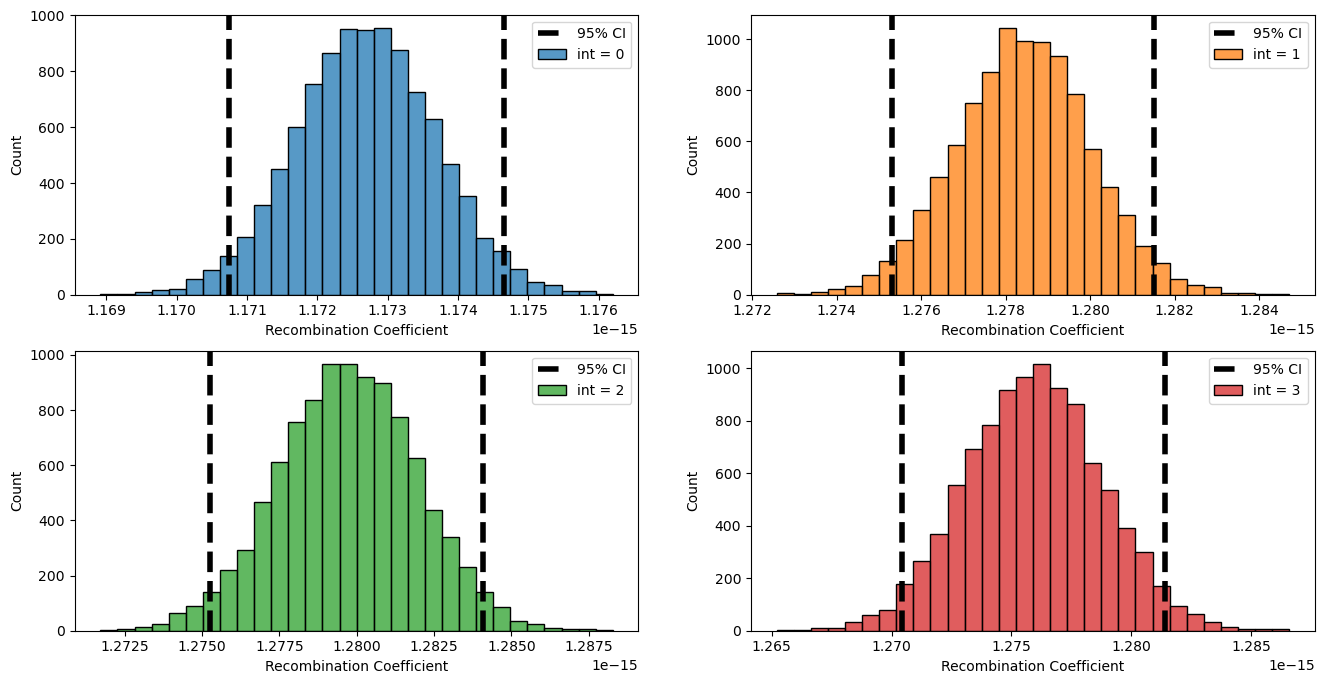

In [ ]:
# Set up the figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 8))

# Load the data
dfs = [load_data(f'interaction_cutoff_{i}.txt') for i in range(4)]

# Loop over all DataFrames and compute bootstrap means
resampled_means_list = [bootstrap_means(df, cutoff) for cutoff, df in enumerate(dfs)]

# Order axes
axes_plot = [axs[i,j] for i in range(2) for j in range(2)]

for plot_i, resampled_means in enumerate(resampled_means_list):
    # Compute 95% confidence interval
    lower_bound = np.percentile(resampled_means, 2.5)
    upper_bound = np.percentile(resampled_means, 97.5)
    mean_val = np.mean(resampled_means)

    # Plot histogram
    sns.histplot(resampled_means, bins=30, kde=False, ax=axes_plot[plot_i], label=f'int = {plot_i}', color = f'C{plot_i}')

    # Add confidence interval
    axes_plot[plot_i].axvline(lower_bound, color='black', linestyle='--', linewidth=4, label='95% CI')
    axes_plot[plot_i].axvline(upper_bound, color='black', linestyle='--', linewidth=4)
    
    # Add legend and label
    axes_plot[plot_i].set_xlabel("Recombination Coefficient")
    axes_plot[plot_i].legend()


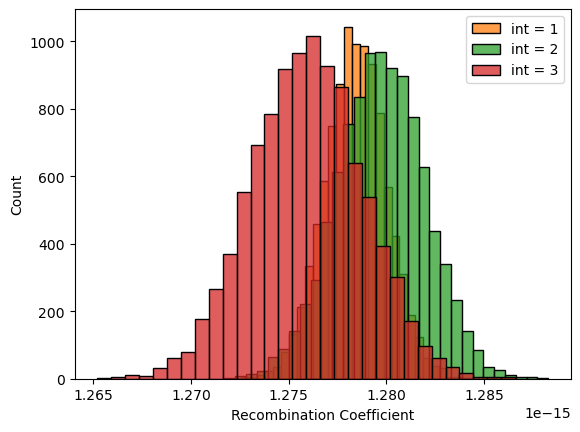

In [ ]:
# Overlay converged plots
for plot_i, resampled_means in enumerate(resampled_means_list[1:]):
    # Compute 95% confidence interval
    lower_bound = np.percentile(resampled_means, 2.5)
    upper_bound = np.percentile(resampled_means, 97.5)

    # Plot histogram
    sns.histplot(resampled_means, bins=30, kde=False, label=f'int = {1+plot_i}', color = f'C{1+plot_i}')

    # Add legend and label
    plt.xlabel("Recombination Coefficient")
    plt.legend()
